In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
z_dim=2

In [3]:
class Autoencoder(nn.Module):
    def __init__(self,z_dim=128):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder =  nn.Sequential(
            nn.Conv2d(1,16, 3, stride=1, padding=1),   # 32x 28x 28]
            nn.ReLU(True),
            nn.Conv2d(16,32, 3, stride=2, padding=1),  # 64x 14x 14
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  #  64x 7x 7
            nn.ReLU(True),
        )
        # Latent space
        self.latent_space = nn.Linear(64 * 7 * 7, z_dim*2)
        # Decoder
        self.decoder_mlp= nn.Sequential(
            nn.Linear(z_dim, 64 * 7 * 7),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # 7x7x32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1), # 14x14x16
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1,3, stride=1, padding=1),  # 28x28x1
            nn.Sigmoid(),
        )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encoding(self,x):
        x = self.encoder(x)

        x = x.reshape(x.size(0), -1)  # flatten the tensor
        latent_params = self.latent_space(x)

        mu, logvar = torch.chunk(latent_params, 2, dim=1)
        return mu, logvar
    def decoding(self,x):
        x=self.decoder_mlp(x).view(x.size(0), 64,7,7)
        x = self.decoder(x)  # reshape the tensor
        return x
    def forward(self, x):
        x = self.encoder(x)

        x = x.reshape(x.size(0), -1)  # flatten the tensor
        latent_params = self.latent_space(x)

        mu, logvar = torch.chunk(latent_params, 2, dim=1)
        z = self.reparameterize(mu, logvar)

        x=self.decoder_mlp(z).view(x.size(0),64,7,7)
        x = self.decoder(x)  # reshape the tensor
        return x,mu, logvar


In [4]:
def loss_function(x_hat,x, mean, log_var,k1,k2):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum') #nn.MSELoss()(x_hat, x)
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return k1*reproduction_loss + k2*KLD


In [5]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [6]:
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

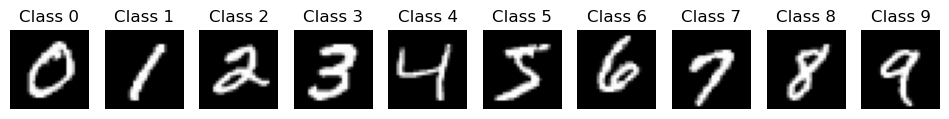

In [7]:
# Create a dictionary to store one sample for each class
samples = {}
for i in range(10):
    samples[i] = None
cpt=0
# Find the first occurrence of each class and store it in the dictionary
for data, target in train_dataset:
    if samples[target] is None:
        samples[target] = data
        cpt+=1
        if cpt==10:
            break

# Plot the samples
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    axes[i].imshow(samples[i][0], cmap='gray')
    axes[i].set_title(f'Class {i}')
    axes[i].axis('off')
plt.show()

In [8]:
# Create a DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=64)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
from torch import optim
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder(z_dim).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [11]:
k1,k2=1,1
# Training
num_epochs = 100
train_losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in train_loader:
        optimizer.zero_grad()

        outputs,mu, logvar = model(images.float().cuda())
        #print(torch.min(outputs).item(),torch.max(outputs).item())
        loss = loss_function(outputs, images.float().cuda(), mu, logvar,k1,k2)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    if epoch % 10==0:
        print('Epoch [{}/{}], Training Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))

Epoch [1/100], Training Loss: 25198.7863
Epoch [11/100], Training Loss: 19656.7660
Epoch [21/100], Training Loss: 19335.2283
Epoch [31/100], Training Loss: 19159.5057
Epoch [41/100], Training Loss: 19037.4550
Epoch [51/100], Training Loss: 18958.0037
Epoch [61/100], Training Loss: 18879.1541
Epoch [71/100], Training Loss: 18831.9946
Epoch [81/100], Training Loss: 18781.2487
Epoch [91/100], Training Loss: 18748.5584


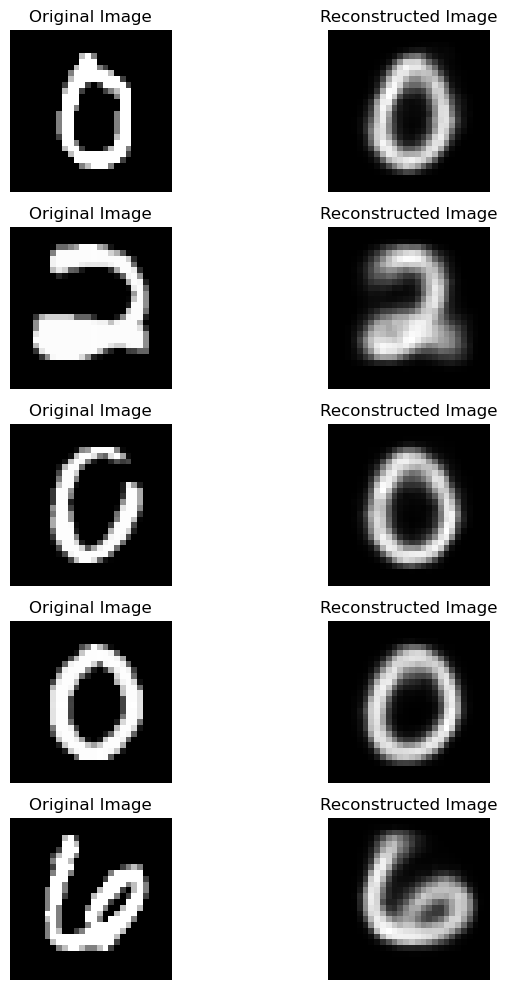

In [12]:
# Select random images from the test set and reconstruct them
num_images = 5
selected_indices = torch.randint(len(test_dataset), size=(num_images,))
reconstructed_images = []
original_images = []
for idx in selected_indices:
    image, _ = test_dataset[idx]
    original_images.append(image[0])
    with torch.no_grad():
        reconstructed_image,_,_ = model(image.cuda().unsqueeze(0))
        reconstructed_images.append(reconstructed_image.squeeze().detach().cpu().numpy().reshape(28,28))

# Plot the original and reconstructed images
fig, axes = plt.subplots(num_images, 2, figsize=(8, 2*num_images))
for i in range(num_images):
    axes[i, 0].imshow(original_images[i], cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstructed_images[i], cmap='gray')
    axes[i, 1].set_title('Reconstructed Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [13]:
# Scatter plot of latent space with respective class colors
latent_points = []
labels = []
with torch.no_grad():
    for images, targets in test_loader:
        latent,_ = model.encoding(images.cuda())
        latent_points.extend(latent.detach().cpu().numpy())
        labels.extend(targets.numpy())

In [14]:
latent_points = np.array(latent_points)
labels = np.array(labels)


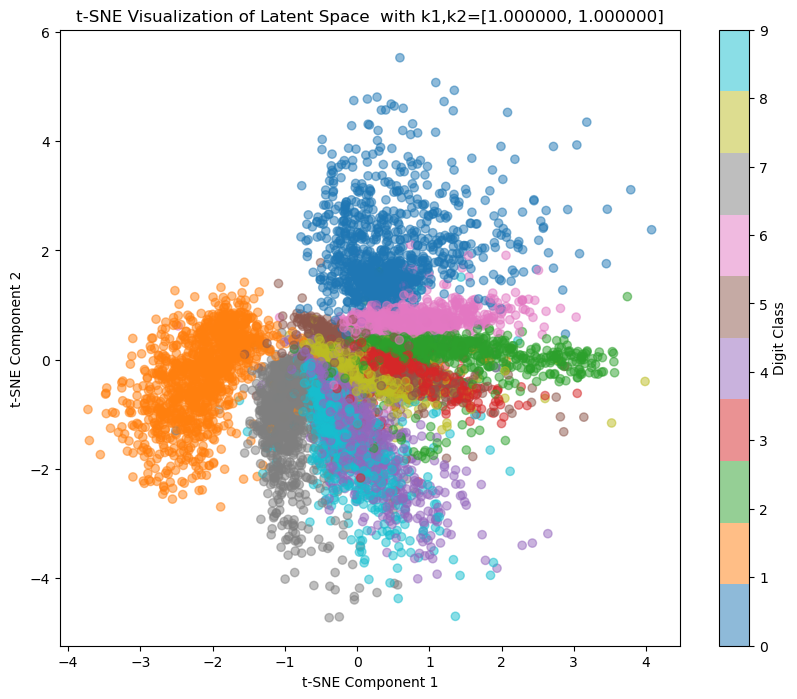

In [15]:
if z_dim>2:
  from sklearn.manifold import TSNE
  # Apply t-SNE to reduce the dimensionality of the latent representations to 2D
  tsne = TSNE(n_components=2, random_state=0)
  latent_2d = tsne.fit_transform(latent_points)
else:
  latent_2d = latent_points
# Plot the 2D latent representations
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=test_dataset.targets, cmap='tab10', alpha=0.5)
plt.colorbar(label='Digit Class')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Latent Space  with k1,k2=[%f, %f]'%(k1,k2))
plt.savefig('1.png')

# Generate images from a given class

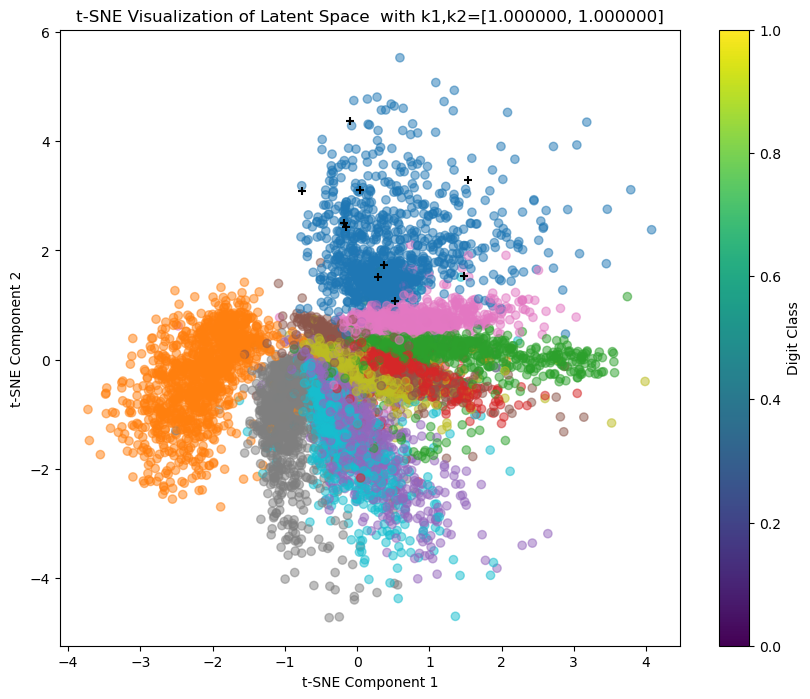

In [16]:
cls_num=0
cls_mu=np.mean(latent_points[labels==cls_num],0)
cls_std=np.std(latent_points[labels==cls_num],0)

x, y = np.random.multivariate_normal(cls_mu, np.diag(cls_std), 10).T

plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=test_dataset.targets, cmap='tab10', alpha=0.5)
plt.scatter(x, y, c='black', marker='+')
plt.colorbar(label='Digit Class')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Latent Space  with k1,k2=[%f, %f]'%(k1,k2))
plt.savefig('1.png')

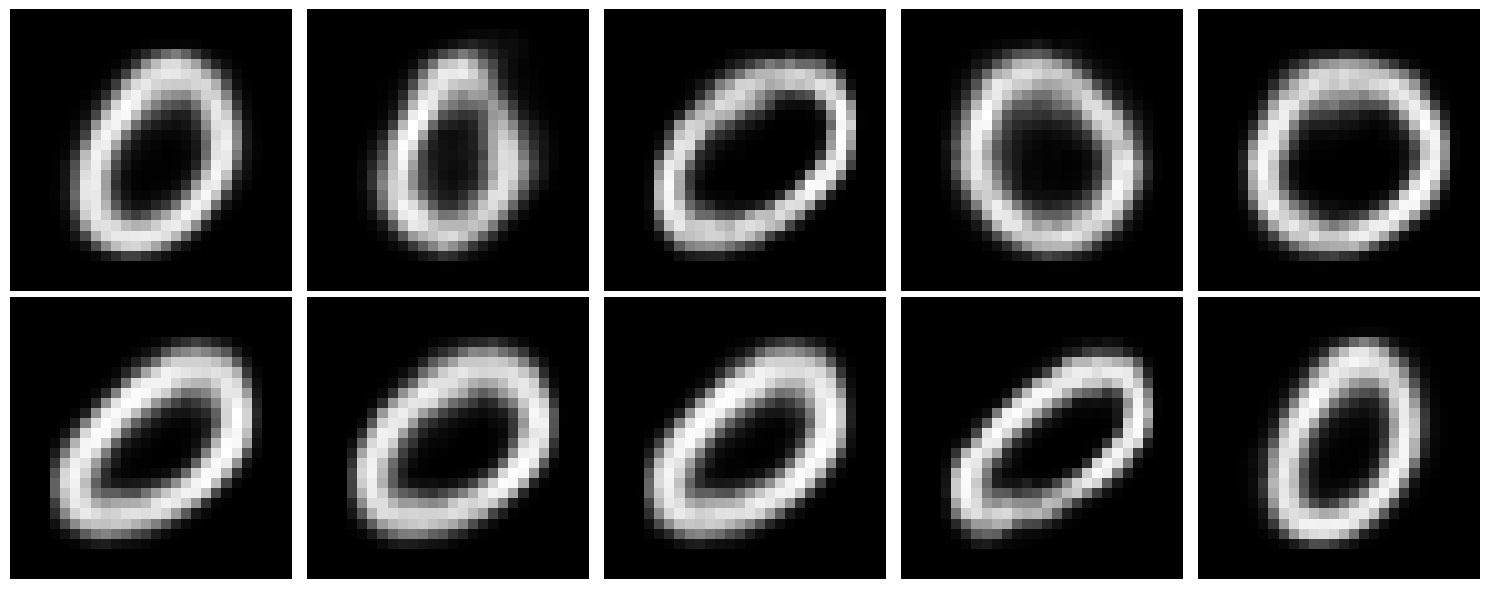

In [17]:
sampled_latent = torch.from_numpy(np.vstack((x,y)).T).cuda().float()
with torch.no_grad():

        reconstructed_images=model.decoding(sampled_latent).clip(0,1).detach().cpu().numpy()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
# Flatten the axes array to simplify iteration
axes = axes.flatten()
# Plot each image
for i, ax in enumerate(axes):
    ax.imshow(reconstructed_images[i,0],'gray')
    ax.axis('off')
# Adjust layout to prevent overlap
plt.tight_layout()
# Show the plot
plt.show()

# Generate images randomly

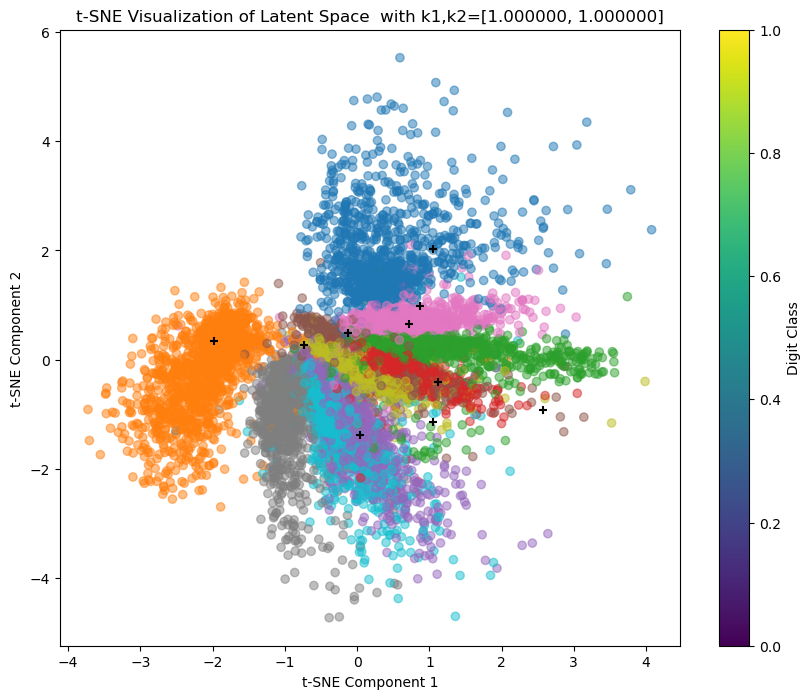

In [18]:
mu=np.mean(latent_points,0)
std=np.std(latent_points,0)

x, y = np.random.multivariate_normal(mu, np.diag(std), 10).T

plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=test_dataset.targets, cmap='tab10', alpha=0.5)
plt.scatter(x, y, c='black', marker='+')
plt.colorbar(label='Digit Class')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Latent Space  with k1,k2=[%f, %f]'%(k1,k2))
plt.savefig('1.png')

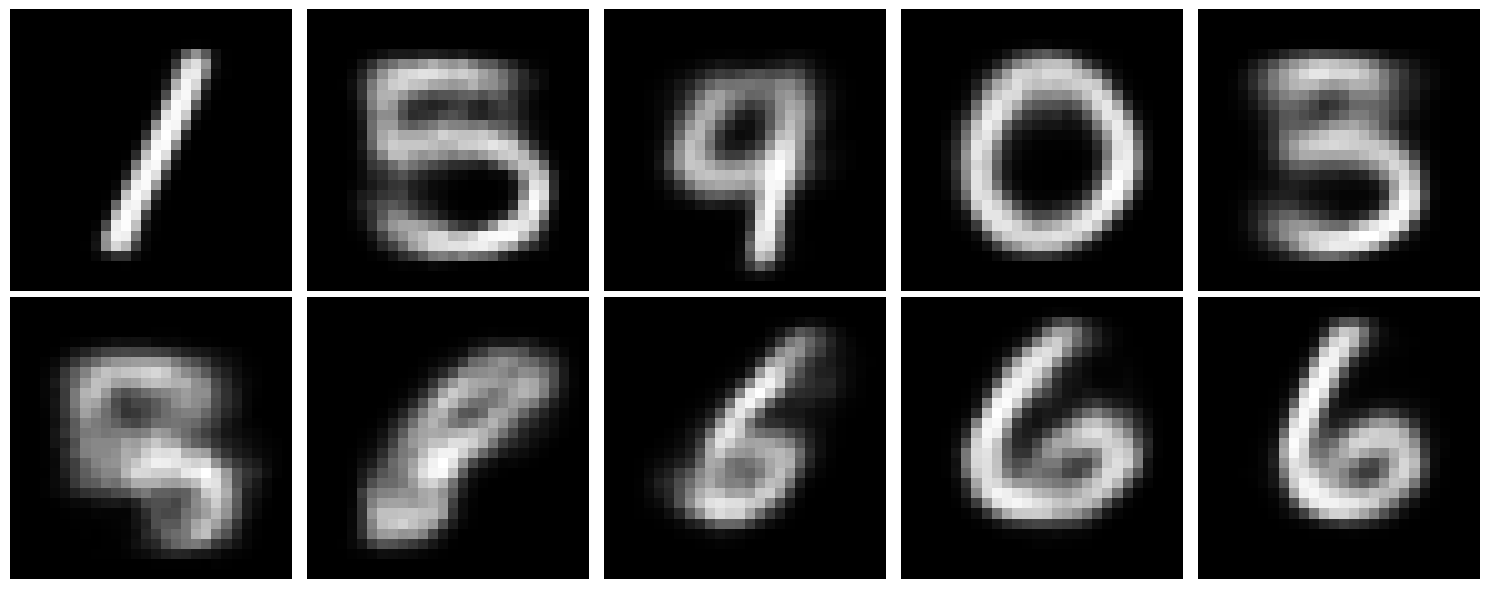

In [19]:
sampled_latent = torch.from_numpy(np.vstack((x,y)).T).cuda().float()
with torch.no_grad():

        reconstructed_images=model.decoding(sampled_latent).clip(0,1).detach().cpu().numpy()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
# Flatten the axes array to simplify iteration
axes = axes.flatten()
# Plot each image
for i, ax in enumerate(axes):
    ax.imshow(reconstructed_images[i,0],'gray')
    ax.axis('off')
# Adjust layout to prevent overlap
plt.tight_layout()
# Show the plot
plt.show()